In [1]:
!nvidia-smi

Sun Jan 23 18:28:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Data hosted at below link (downloading it)
!wget https://www.dropbox.com/s/tlxserrdhe240lu/archive.zip
# Unzipping the data
!unzip -q "archive.zip"

--2022-01-23 18:28:15--  https://www.dropbox.com/s/tlxserrdhe240lu/archive.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.67.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.67.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/tlxserrdhe240lu/archive.zip [following]
--2022-01-23 18:28:15--  https://www.dropbox.com/s/raw/tlxserrdhe240lu/archive.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfaa00936ac76955dc6bc16d9a9.dl.dropboxusercontent.com/cd/0/inline/BeWXIUHLcFn1V-ZLCqYgmBp0Sh9mRp1Lmh3HzsDqMSA-gLIj6ibv-U-8L36ToP_cqw8tqXHLgSv1NQkwP-uo5UdYSFuGmWnQ8tDFpFm1vOfTy-AYmCllXuFBaAqzD_Wo3RFQJJUCeK5aHK1RwBrkhUwm/file# [following]
--2022-01-23 18:28:16--  https://ucfaa00936ac76955dc6bc16d9a9.dl.dropboxusercontent.com/cd/0/inline/BeWXIUHLcFn1V-ZLCqYgmBp0Sh9mRp1Lmh3HzsDqMSA-gLIj6ibv-U-8L36ToP_cqw8tqXHLgSv1NQkwP-uo5UdYSF

In [3]:
# Imports required for this project
import tensorflow as tf #used to build deep learning models and data processing pipelines
import numpy as np  #for fast numerical calculations
import matplotlib.pyplot as plt #for plotting model training and evaluation metrices
from pathlib import Path #used in loading, recursive and batch structured directories

In [4]:
# Creating the Pathlib PATH objects
# having train, test and validation directories 
train_path = Path("chest_xray/train/")
validation_path = Path("chest_xray/test")
test_path = Path("chest_xray/val")
#these internally have pneumonia and normal chest xray as folder and images

In [5]:
# Datapath object has a method called glob which iretares over files in the directory.
# Collecting all the Paths Inside "Normal" and "Pneumonia" folders of the above paths
train_image_paths = train_path.glob("*/*")  #we get all the files that are two layers below 
val_image_paths = validation_path.glob("*/*") #for both train and validation path

# Output is a Generator object
print(train_image_paths) #glob method returns a generator object

<generator object Path.glob at 0x7f155892f850>


In [6]:
# Convert Generator Object to List of elements 
train_image_paths = list(train_image_paths)
val_image_paths = list(val_image_paths)

# Now the outputs are "PosixPath" objects
print(train_image_paths[:3])  #posixpath is for unix based path systems

[PosixPath('chest_xray/train/PNEUMONIA/person1217_virus_2063.jpeg'), PosixPath('chest_xray/train/PNEUMONIA/person43_bacteria_213.jpeg'), PosixPath('chest_xray/train/PNEUMONIA/person533_bacteria_2245.jpeg')]


In [7]:
# Convert Posix paths to normal strings
train_image_paths = list(map(lambda x : str(x) , train_image_paths))
val_image_paths = list(map(lambda x : str(x) , val_image_paths)) 

print(train_image_paths[:3]) #printing as list

['chest_xray/train/PNEUMONIA/person1217_virus_2063.jpeg', 'chest_xray/train/PNEUMONIA/person43_bacteria_213.jpeg', 'chest_xray/train/PNEUMONIA/person533_bacteria_2245.jpeg']


In [8]:
# Collect Length for Training and Validation Datasets
train_dataset_length = len(train_image_paths)
val_dataset_length = len(val_image_paths)
#just to keep track of it

In [9]:
# Every Image has Label in its path , so lets slice it 
LABELS = {'NORMAL' : 0 , 'PNEUMONIA' : 1} #assigning unique label to each class of images
INV_LABELS = {0 : 'NORMAL', 1 : 'PNEUMONIA'} #inverse mapping disctionary

def get_label(path : str) -> int:
    return LABELS[path.split("/")[-2]]  #getting the labels as it is in the second last of the name while splitting over / 

#returns the label of that image path after assigning its unique label to it

train_labels = list(map(lambda x : get_label(x) , train_image_paths))
val_labels = list(map(lambda x : get_label(x) , val_image_paths))

#we apply this function over all the train and validation image paths to create their labels respectively

print(train_labels[:3])

[1, 1, 1]


In [10]:
# Now we have all training, validation image paths and their respective labels 
# how to load images from their path

#There are different python libraries that load the image paths as a vector of pixels
# OPEN CV, SK IMAGE, PIL(PYTHON IMAGE LIBRARY) and most important is (TF2.0)
# we can directly load images using tensorflow 

BATCH_SIZE = 32

# Function used for Transformation
def load_and_transform(image , label , train = True): #train=true means used in training set
    image = tf.io.read_file(image) #takes in a string file path as arguments and returns an encoded string
                                   #string of that file after reading it
    image = tf.io.decode_jpeg(image , channels = 3) #Takes argument as content which is the encoded string returned by
                                                    #TF readfile function and returns tensor of unsigned 8bit integers
    image = tf.image.resize(image , [224 , 224] , method="nearest") #takes image that is returned by tensor
                                                    #size to which it will resize, method is used to 
    if train:                                       #interpolate the image for compression or enlarging
        image = tf.image.random_flip_left_right(image) #data augmentation here image
    return image , label #returning tensor to its respective lables
    #resize image according to model input size
    #### we use RESNET 50 which has input image size of 224 according to its document

# Function used to Create a Tensorflow Data Object
def get_dataset(paths , labels , train = True): #takes image path their labels and Train=true means used in training set
    image_paths = tf.convert_to_tensor(paths) #converting paths and labels into tensors
    labels = tf.convert_to_tensor(labels)

#Creating dataset objects for each paths and labels using method provided by api
    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

#zip both the datasets and apply random shuffle (now we can iterate over image paths and labels at once)
    dataset = tf.data.Dataset.zip((image_dataset , label_dataset)).shuffle(1000)

#Now that we have a data set object which can iterate on images and labels, 
#we can go ahead and apply our load and transforme method to this.
    dataset = dataset.map(lambda image , label : load_and_transform(image , label , train))
    dataset = dataset.repeat() #used to infinetely iterate over the dataset
    dataset = dataset.shuffle(2048)#shuffle again
    dataset = dataset.batch(BATCH_SIZE) #batch the dataset object with batch size

    return dataset

###If the batch size is higher, then more images would be brought into memory and which consume high ram

###If the batch size is lower than less, images would be brought into memory and training time would be higher.

In [11]:
# Creating Train Dataset object and Verifying it
%time train_dataset = get_dataset(train_image_paths , train_labels)

image , label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 542 ms, sys: 387 ms, total: 929 ms
Wall time: 2.75 s
(32, 224, 224, 3)
(32,)


PNEUMONIA


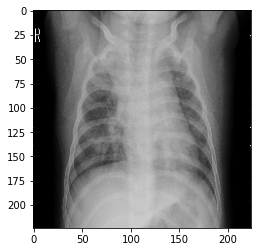

In [12]:
# View a sample Train Image
print(INV_LABELS[label[0].numpy()]) #converting images to numpy arrays and change labels to understandable texts
plt.imshow(image[0].numpy().reshape(224 , 224 , 3)) #using inverse label dict and plotting the image

In [13]:
#test validation dataset objects
%time val_dataset = get_dataset(val_image_paths , val_labels , train = False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 19.1 ms, sys: 888 µs, total: 20 ms
Wall time: 21.1 ms
(32, 224, 224, 3)
(32,)


PNEUMONIA


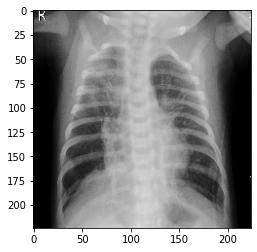

In [14]:
# View a sample Validation Image
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224 , 224 , 3))

In [15]:
# Building ResNet50 model
from tensorflow.keras.applications import ResNet50V2 #importing model

backbone = ResNet50V2( #creating backbone model
    input_shape=(224, 224, 3), #shape of processed images
    include_top=False  # Because by default in resnet final layer includes 1000 classes but we need only 2 
)

model = tf.keras.Sequential([ #to join multiple tensorflow graphs sequencially
    backbone, #the data will first flow through the backbone model
    tf.keras.layers.GlobalAveragePooling2D(),
    #This layer will average all the signals over final convolution blocks, 
    #we connect this layer to a single neuron with activation sigmoid.
    tf.keras.layers.Dense(1, activation='sigmoid') #single neuron with sigmoid as yes/no problem
])

model.summary() #printing summary

94683136/94668760 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 23,521,409
Non-trainable params: 45,440
_________________________________________________________________


####We see three layers and their respective parameter count,the total parameters we need to train in ResNet 50 are approximately 23 million.

###This parameter counts increase if you try to select more complex models such as resnet 101 or Resnet 152

In [16]:
# Compiling your model by providing the Optimizer , Loss and Metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), #optimizer is adam as it is most optimised
    loss = 'binary_crossentropy', #for binary here 2 classes, for more than 2 we use categorical crossentropy
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)  #The metrics are the stats that we want to keep track of while training our model 
   #as this is a medical problem, we added precision and recall to the metrics list.

In [17]:
# Defining our callbacks 
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5",verbose=1,save_best_only=True,save_weights_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)
#self defining code

In [18]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_length//BATCH_SIZE, #total length of training data by batch size which gives no of batches per epoch
    epochs=12, #no of epochs we want to train (12 is optimum we checked)
    callbacks=[checkpoint , early_stop], #passing callbacks as list
    validation_data=val_dataset,
    validation_steps = val_dataset_length//BATCH_SIZE, #same for validation steps 
)

Epoch 1/15
163/163 [==============================] - ETA: 0s - loss: 0.1618 - accuracy: 0.9427 - precision: 0.9615 - recall: 0.9673
Epoch 00001: val_loss improved from inf to 447.81018, saving model to best_weights.h5
163/163 [==============================] - 185s 963ms/step - loss: 0.1618 - accuracy: 0.9427 - precision: 0.9615 - recall: 0.9673 - val_loss: 447.8102 - val_accuracy: 0.5954 - val_precision: 0.5954 - val_recall: 1.0000
Epoch 2/15
163/163 [==============================] - ETA: 0s - loss: 0.1083 - accuracy: 0.9595 - precision: 0.9725 - recall: 0.9738
Epoch 00002: val_loss improved from 447.81018 to 1.86841, saving model to best_weights.h5
163/163 [==============================] - 156s 958ms/step - loss: 0.1083 - accuracy: 0.9595 - precision: 0.9725 - recall: 0.9738 - val_loss: 1.8684 - val_accuracy: 0.4819 - val_precision: 0.6138 - val_recall: 0.4672
Epoch 3/15
163/163 [==============================] - ETA: 0s - loss: 0.0892 - accuracy: 0.9678 - precision: 0.9773 - reca

When we were training our model, we collected the results of the training in a variable called history.

History contains all the progress of a model metrics, while training, accuracy and loss are default metrics.

We have additionally parsed in precision and recall while training. 

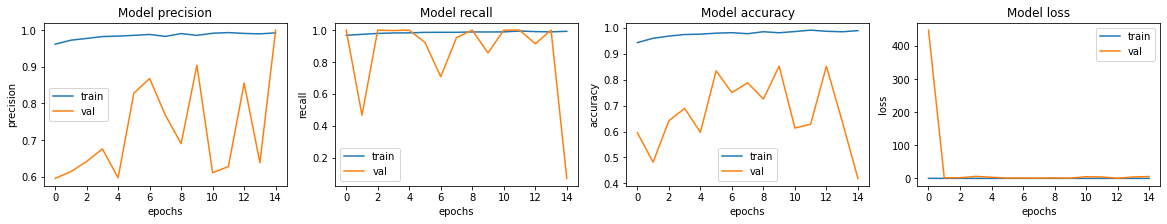

In [19]:
# Interpreting the Metrics 
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']): #we are iterating over all metrices
    ax[i].plot(history.history[met])         #plotting graph for each metric in a subplot
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
    #blue line is the progress of the metric training data and 
    #orange line in validation data

When it comes to precision and recall, we want the validation progress to be gradually moving higher and touching the training of gradually.


###Mainly recall, it is the most important metric in medical problem statements.

In [20]:
# Saving the best Model

# Load the best weights
model.load_weights("best_weights.h5")
# Save the whole model (weigths + architecture)
model.save("model.h5")
# we have to make sure the architecture remains same we cannot save eights in resnet 50 and load in resnet 101

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [21]:
# Loading the whole model
loaded_model = tf.keras.models.load_model("model.h5")

Create a Testing Dataset and validate it 

In [22]:
# Create a Dataset Object for 'Testing' Set just the way we did for Training and Validation
test_image_paths = list(test_path.glob("*/*"))
test_image_paths = list(map(lambda x : str(x) , test_image_paths))
test_labels = list(map(lambda x : get_label(x) , test_image_paths))

test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

#all codes are same but we dont do image augmentation

def decode_image(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [224 , 224] , method="nearest")
    return image , label

test_dataset = (
     tf.data.Dataset
    .from_tensor_slices((test_image_paths, test_labels))
    .map(decode_image)
    .batch(BATCH_SIZE)
)

In [24]:
# Verify Test Dataset Object
#Here we have not used the repeat function because we just 
#want to perform one iteration over the whole dataset 
image , label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

(16, 224, 224, 3)
(16,)


PNEUMONIA


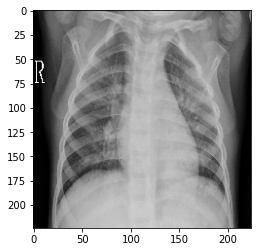

In [25]:
# View a sample Validation Image
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224 , 224 , 3))

In [27]:
# Evaluating the loaded model
loss, acc, prec, rec = loaded_model.evaluate(test_dataset)

print(" Testing Loss : " , loss)
print(" Testing Acc : " , acc)
print(" Testing Precision " , prec)
print(" Testing Recall " , rec)

1/1 [==============================] - 0s 270ms/step - loss: 0.1127 - accuracy: 0.9375 - precision: 1.0000 - recall: 0.8750
 Testing Loss :  0.11271041631698608
 Testing Acc :  0.9375
 Testing Precision  1.0
 Testing Recall  0.875
